# DDPLKO Moduł 10 - praca domowa - Binary classification

To dziesiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [x] Wybór 2 klas ze zbioru Open Images (https://storage.googleapis.com/openimages/web/index.html)
- [x] Wykonanie dwóch treningów (może być własny model, lepiej transfer learning):
  - [x] Bez ważonego lossu
  - [x] z ważonym lossem
- [x] UWAGA - w obu treningach monitoruj balanced accuracy!
- [ ] Udostępnij po 1 przykładowym zdjęciu z wybranych klas oraz wykres z porównaniem wyników validation balanced accuracy na Discordzie `#klasyfikacja-wyniki`

>Aby pobrać zdjęcia dla 2 klas możesz skorzystać za załączonych notebooków

W przypadku problemów z wielkością tego zbioru:
- możesz pracować na zmniejszonej rozdzielczości np. 32x32px
- możesz zmniejszyć liczbę próbek, ale zachowując ich stosunek (nie wyrównuj liczebności, by móc skorzystać z balanced accuracy)

Extra - dodatkowo możesz:
- wytrenować modele różnej wielkości np. EffNetB0 i EffNetB2 czy R18, R50, R101
- narysować krzywe ROC i PR z porównaniem modeli

In [1]:
import glob
from collections import defaultdict
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import timm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.utils import tensorboard
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm.notebook import tqdm
import timm
from datetime import datetime

# 2 classes from OpenImages

In [2]:
def imgfile2np(file, size=(150, 150)):
    img = cv2.imread(file)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype='float32') / 255.0
    return img

In [3]:
main_dir = "/home/muzg/10.09/openimages/images3"

In [4]:
X_train = []
X_val = []
transform = transforms.ToTensor()

for i, file in enumerate(glob.glob(main_dir + r"/train/class_1/*")):
    X_train.append(imgfile2np(file))

for i, file in enumerate(glob.glob(main_dir + r"/train/class_2/*")):
    X_train.append(imgfile2np(file))

for i, file in enumerate(glob.glob(main_dir + r"/validation/class_1/*")):
    X_val.append(imgfile2np(file))

for i, file in enumerate(glob.glob(main_dir + r"/validation/class_2/*")):
    X_val.append(imgfile2np(file))

In [5]:
y_train = np.array([0] * len(glob.glob(main_dir + r"/train/class_1/*")) +
                   [1] * len(glob.glob(main_dir + r"/train/class_2/*")),
                   dtype='float32')
y_val = np.array([0] * len(glob.glob(main_dir + r"/validation/class_1/*")) +
                 [1] * len(glob.glob(main_dir + r"/validation/class_2/*")),
                 dtype='float32')


In [6]:
X_train = torch.from_numpy(np.array(X_train)).permute(0, 3, 1, 2)
X_val = torch.from_numpy(np.array(X_val)).permute(0, 3, 1, 2)


In [7]:
y_train = torch.from_numpy(y_train).unsqueeze(1)
y_val = torch.from_numpy(y_val).unsqueeze(1)

In [29]:
choices = np.random.randint(0, len(X_val), 500)
X_test = X_val[choices]
y_test = y_val[choices]

In [9]:
batch_size = 128
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, num_workers=20)
val_dataloader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, num_workers=20, shuffle=True)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
def plot_results(histories, titles):
    if type(histories) != list:
        histories = [histories]
        titles = [titles]
    plt.figure(figsize=(15, 15))

    plt.subplot(221)
    for history, title in zip(histories, titles):
        plt.plot(history['loss_train'], label=title + ' train')
    plt.title('Loss')
    plt.legend()

    plt.subplot(223)
    for history, title in zip(histories, titles):
        plt.plot(history['loss_val'], label=title + ' val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(222)
    for history, title in zip(histories, titles):
        plt.plot(history['accuracy_train'], label=title + ' train')
        plt.plot(history['balanced_accuracy_train'],
                 label=title + ' balanced train')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(224)
    for history, title in zip(histories, titles):
        plt.plot(history['accuracy_val'], label=title + ' val')
        plt.plot(history['balanced_accuracy_train'],
                 label=title + ' balanced val')
    plt.title('Accuracy')
    plt.legend()


# Model

In [12]:
epochs = 30
model = 'resnet50'

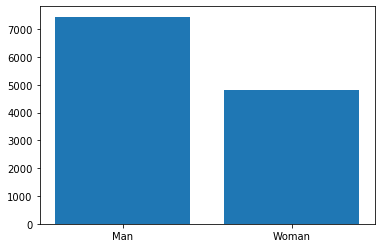

In [13]:
class0 = np.sum([1 for x in y_train if x == 0])
class1 = np.sum([1 for x in y_train if x == 1])
plt.bar(np.arange(2), [class0, class1], tick_label=["Man", "Woman"])
plt.show()

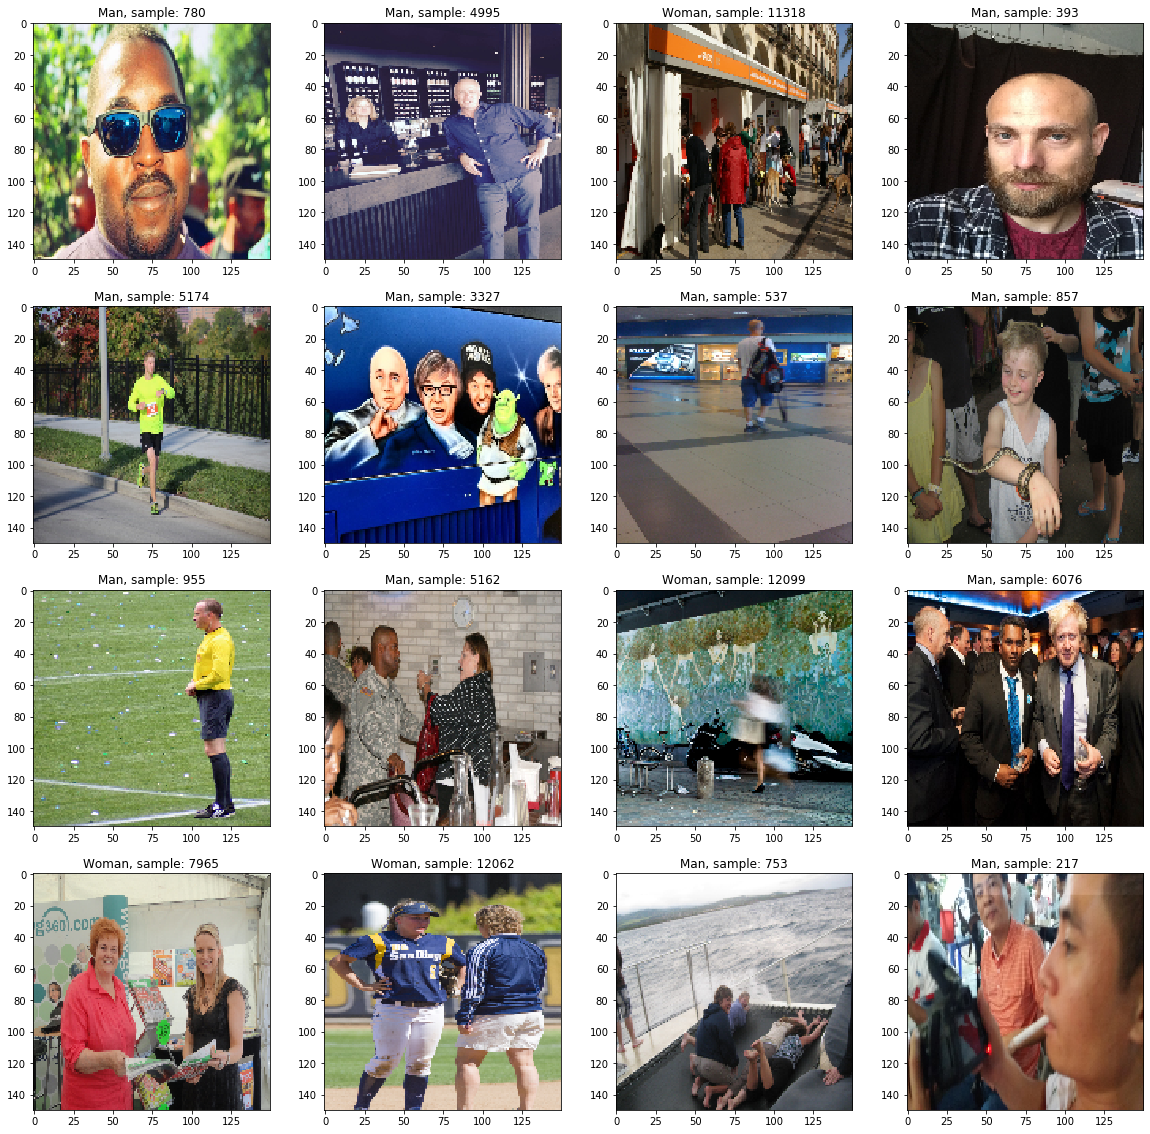

In [14]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    n = random.randint(0, len(X_train))
    plt.imshow(X_train[n].permute(1,2,0))
    plt.title(f"Man, sample: {n}" if y_train[n] == 0 else f"Woman, sample: {n}")

In [15]:
class Classifier(pl.LightningModule):

    def __init__(self, model, use_weights=False):
        super().__init__()

        self.model = model
        self.model.fc = nn.Linear(2048, 1)
        total = len([1 for _ in model.parameters()])
        for i, param in enumerate(self.model.parameters()):
            if i >= (total - 4):
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.history = defaultdict(lambda: [])
        self.loss_train = []
        self.loss_val = []
        self.use_weights = use_weights
        self.weights = torch.Tensor([((class0 + class1) - class1) / class1
                                     ]).to(device)
        self.correct = 0
        self.predictions = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        if self.use_weights:
            loss = nn.BCEWithLogitsLoss(pos_weight=self.weights)(y_hat, y)
        else:
            loss = nn.BCEWithLogitsLoss()(y_hat, y)
        y_hat = nn.Sigmoid()(y_hat)
        pred = (y_hat > 0.5) * 1
        acc = pred.eq(y.view_as(pred)).sum().item() / y_hat.shape[0]
        bacc = balanced_accuracy_score(y.detach().cpu().numpy().astype(int),
                                       pred.cpu())
        return {'loss': loss, 'accuracy': acc, 'balanced_accuracy': bacc}

    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        mean_bacc = np.stack([x['balanced_accuracy'] for x in outputs]).mean()
        self.history['loss_train'].append(mean_loss.detach().cpu().item())
        self.history['accuracy_train'].append(mean_acc.item())
        self.history['balanced_accuracy_train'].append(mean_bacc.item())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        if self.use_weights:
            loss = nn.BCEWithLogitsLoss(pos_weight=self.weights)(y_hat, y)
        else:
            loss = nn.BCEWithLogitsLoss()(y_hat, y)
        y_hat = nn.Sigmoid()(y_hat)
        pred = (y_hat > 0.5) * 1
        acc = pred.eq(y.view_as(pred)).sum().item() / y_hat.shape[0]
        bacc = balanced_accuracy_score(y.detach().cpu().numpy().astype(int),
                                       pred.cpu())
        self.predictions.append(nn.Sigmoid()(self.forward(X_test.to(device))))
        return {'loss': loss, 'accuracy': acc, 'balanced_accuracy': bacc}

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        mean_bacc = np.stack([x['balanced_accuracy'] for x in outputs]).mean()
        self.history['loss_val'].append(mean_loss.detach().cpu().item())
        self.history['accuracy_val'].append(mean_acc.item())
        self.history['balanced_accuracy_val'].append(mean_bacc.item())

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optim,
                                                    step_size=100,
                                                    gamma=0.1)
        return [optim], [scheduler]

In [ ]:
model = timm.create_model(model, pretrained=True)
unweighted = Classifier(model)
trainer = pl.Trainer(max_epochs=epochs,
                     gpus=1,
                     log_every_n_steps=4,
                     num_sanity_val_steps=1)
trainer.fit(unweighted, train_dataloader, val_dataloader)

In [16]:
def plot_history(history, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title)

    plt.subplot(121)
    plt.plot(history['accuracy_train'], label='train')
    plt.plot(history['accuracy_val'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history['loss_train'], label='train')
    plt.plot(history['loss_val'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

# Training - no class weights

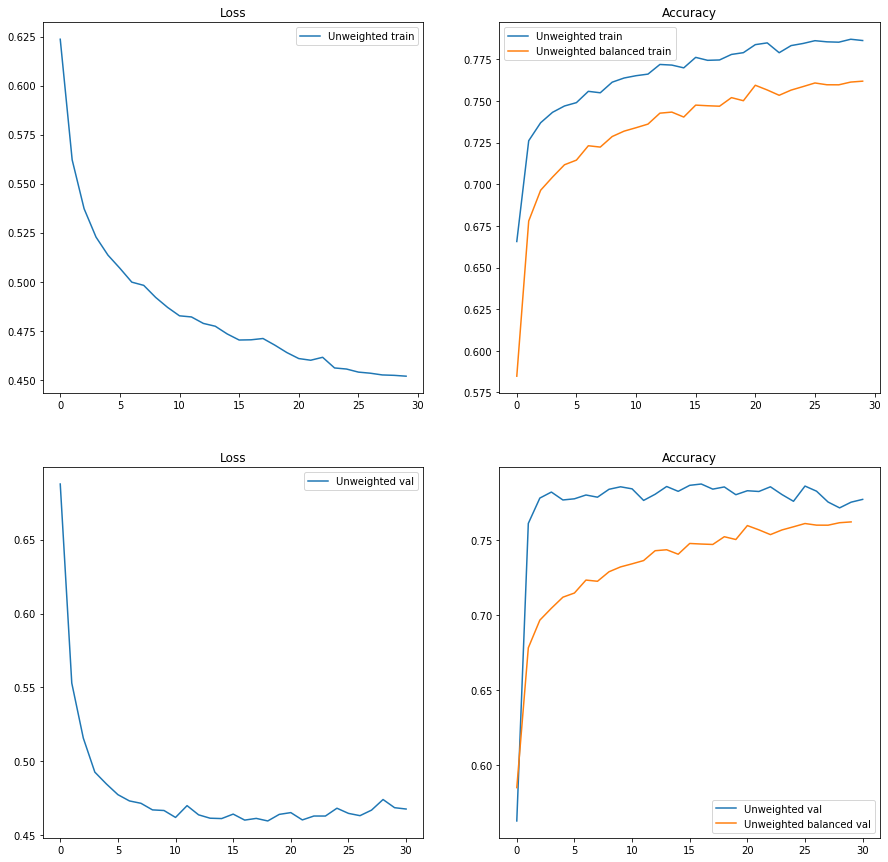

In [18]:
plot_results(unweighted.history, 'Unweighted')

# Training - weighted loss

In [ ]:
model = timm.create_model('resnet50', pretrained=True)
weighted = Classifier(model, use_weights=True)
trainer = pl.Trainer(max_epochs=epochs,
                     gpus=1,
                     log_every_n_steps=4,
                     num_sanity_val_steps=1)
trainer.fit(weighted, train_dataloader, val_dataloader)

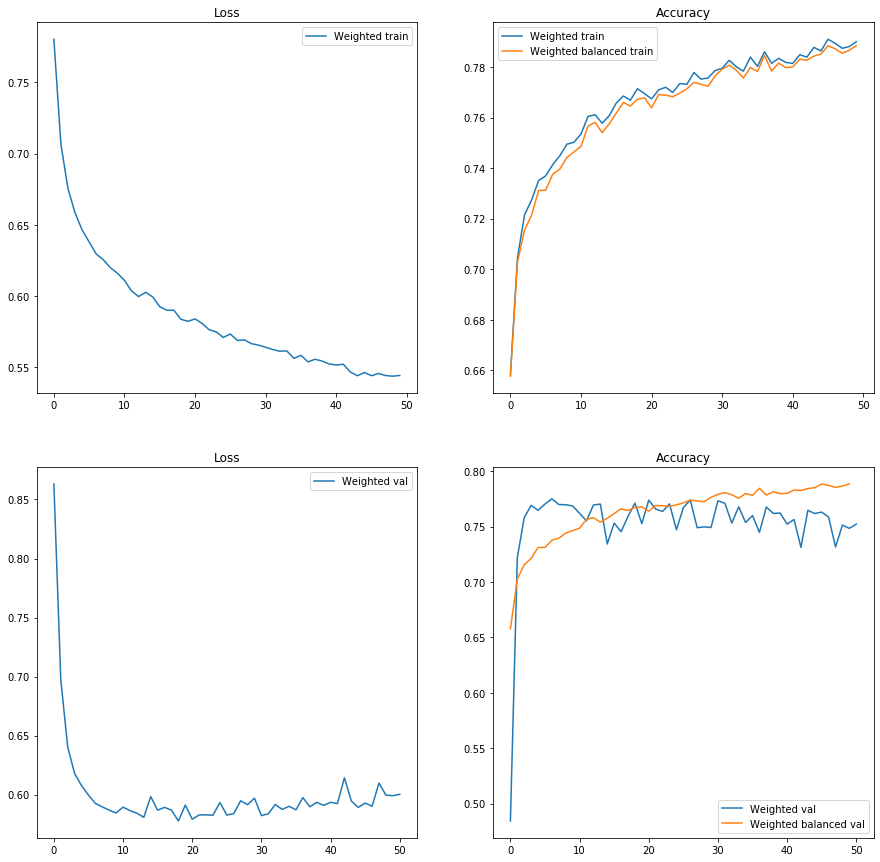

In [33]:
plot_results(weighted.history, 'Weighted')

# Balanced accuracy - without vs with weighted loss

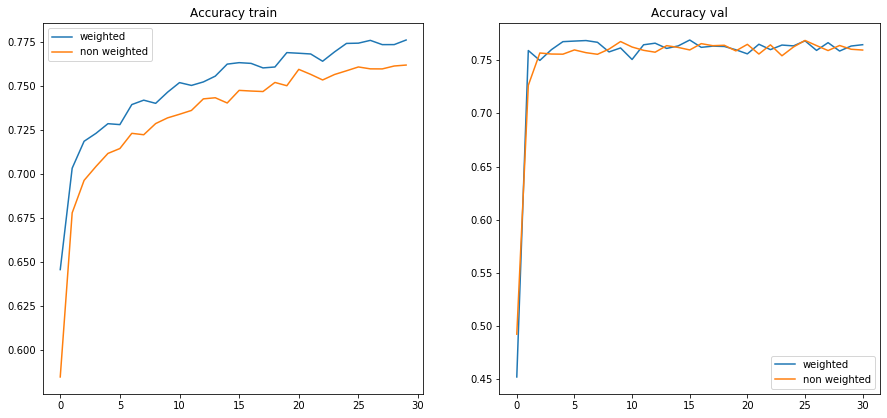

In [23]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(weighted.history['balanced_accuracy_train'], label='weighted')
plt.plot(unweighted.history['balanced_accuracy_train'], label='non weighted')
plt.title("Accuracy train")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(weighted.history['balanced_accuracy_val'], label='weighted')
plt.plot(unweighted.history['balanced_accuracy_val'], label='non weighted')
plt.title("Accuracy val")
plt.legend()
plt.show()

# Summary / extra

In [26]:
def plot_roc(y_true, y_pred, label='', title='', color=(0.1, 0.2, 0.5)):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc_score = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.plot(
        fpr, tpr, color=color
    )  #, label=label + ' AUC = {0:0.4f}'.format(roc_auc_score), color=color)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    #plt.legend()


def plot_pr(y_true, y_pred, label='', title='', color=(0.1, 0.2, 0.5)):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred)

    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])

    plt.plot(
        recall, precision, color=color
    )  #, label=label+' AP = {0:0.4f}'.format(avg_precision), color=color)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    #plt.legend()

In [36]:
y_pred1 = unweighted(X_val).detach().cpu()
y_pred2 = weighted(X_val).detach().cpu()

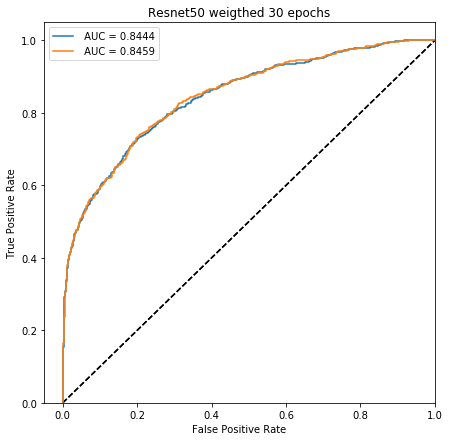

In [37]:
plt.figure(figsize=(7, 7))
plot_roc(y_val, y_pred1, title='Resnet50 30 epochs')
plot_roc(y_val, y_pred2, title='Resnet50 weigthed 30 epochs')

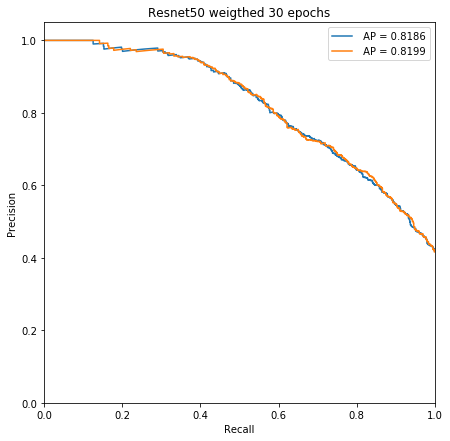

In [38]:
plt.figure(figsize=(7, 7))
plot_pr(y_val, y_pred1, title='Resnet50 30 epochs')
plot_pr(y_val, y_pred2, title='Resnet50 weigthed 30 epochs')

In [ ]:
model = timm.create_model('resnet50', pretrained=True)
weighted = Classifier(model, use_weights=True)
trainer = pl.Trainer(max_epochs=50,
                     gpus=1,
                     log_every_n_steps=4,
                     num_sanity_val_steps=1)
trainer.fit(weighted, train_dataloader, val_dataloader)

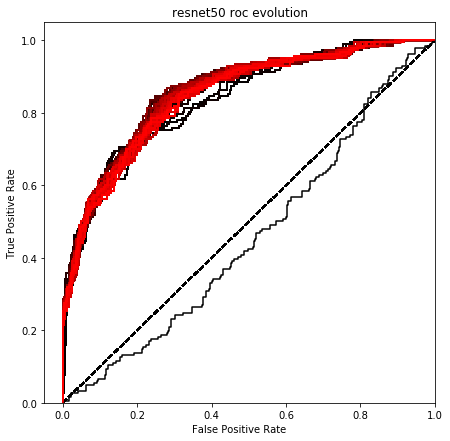

In [31]:
plt.figure(figsize=(7, 7))
for i, pred in enumerate(weighted.predictions):
    plot_roc(y_test,
             pred.cpu(),
             title='resnet50 roc evolution',
             color=(i / len(weighted.predictions), 0, 0))


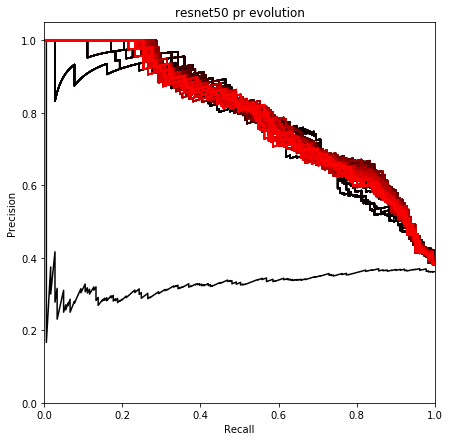

In [32]:
plt.figure(figsize=(7, 7))
for i, pred in enumerate(weighted.predictions):
    plot_pr(y_test,
            pred.cpu(),
            title='resnet50 pr evolution',
            color=(i / len(weighted.predictions), 0, 0))
